![QF-Logo](https://quantumformalism.academy/img/qf-up.png)

# Hamiltonian Simulation: The Transverse-Field Ising Model
### Exploring Exact Evolution and Trotterization Approximations

This notebook supplements **Lecture 6: Quantum Simulation**. We will explore:

- The **Transverse-Field Ising Model (TFIM)**, a fundamental model in quantum magnetism.
- **Exact time evolution** of quantum states using the matrix exponential, $U(t) = e^{-iHt}$.
- **Scaling simulation** from a simple two-qubit system to a 2D lattice.
- **Trotterization** (Lie-Trotter product formula) as a method to approximate the evolution, essential for digital quantum simulation.
- The connection to the **Baker-Campbell-Hausdorff (BCH)** formula for analyzing approximation errors.

### What You Will Learn
- How to construct Hamiltonians for spin systems like the TFIM.
- How to compute exact time evolution numerically.
- The challenges of simulating non-commuting Hamiltonians.
- The theoretical basis and implementation of Trotterization.
- How Lie theory (via BCH) helps understand the errors in quantum simulation algorithms.

This notebook is designed for those familiar with linear algebra and the basics of quantum mechanics, providing mathematical insights relevant to quantum computing experts.

## The Transverse-Field Ising Model (TFIM)

The TFIM is a cornerstone model in condensed matter physics, describing interacting quantum spins (qubits) in an external magnetic field. It captures phenomena like quantum phase transitions.

The Hamiltonian $H$ generally consists of two parts:
1.  **Interaction Term ($H_{int}$):** Describes the coupling between neighboring spins. In the Ising model, this is typically a $\sigma^z \sigma^z$ interaction, favoring alignment or anti-alignment of spins along the z-axis.
2.  **Transverse Field Term ($H_{field}$):** Represents an external magnetic field applied perpendicularly (transverse) to the interaction axis, usually along the x-axis ($σ^x$). This term introduces quantum fluctuations.

For a system of $n$ qubits, the general form is:
$$ H = J \sum_{\langle i,j \rangle} Z_i Z_j + h \sum_{i=1}^n X_i $$
Where:
- $Z_i$ and $X_i$ are the Pauli Z and X operators acting on qubit $i$.
- $J$ is the coupling strength between neighboring spins $\langle i,j \rangle$.
- $h$ is the strength of the transverse field.

Let's start by defining the basic building blocks: Pauli matrices and the tensor product.

In [1]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt

# Define the Pauli matrices and the identity.
X = np.array([[0, 1],
              [1, 0]], dtype=complex)
Z = np.array([[1, 0],
              [0, -1]], dtype=complex)
Y = np.array([[0, -1j],
              [1j, 0]], dtype=complex) # Included Y for completeness, though not used in standard TFIM
I = np.eye(2, dtype=complex)

# Define a helper for the tensor (Kronecker) product.
def tensor(A, B):
    """Computes the Kronecker product of two matrices."""
    return np.kron(A, B)

# Set a consistent plotting style
plt.style.use('seaborn-v0_8-darkgrid')

### Example: Two-Qubit TFIM

Let's construct the Hamiltonian for the simplest non-trivial case: two interacting qubits ($n=2$). The interaction is only between qubit 0 and qubit 1.

$$ H = J (Z_0 \otimes Z_1) + h (X_0 \otimes I + I \otimes X_1) $$

In matrix form, $Z_0 \otimes Z_1 = (Z \otimes I)(I \otimes Z)$ becomes `tensor(Z, Z)`, $X_0 \otimes I$ becomes `tensor(X, I)`, and $I \otimes X_1$ becomes `tensor(I, X)`.

In [2]:
# Hamiltonian parameters for the 2-qubit system:
J = 1.0   # Coupling strength for the interaction (Z ⊗ Z)
h = 0.5   # Transverse field strength for the X terms

# Construct the Hamiltonian parts.
# Interaction term: J * (Z ⊗ Z)
H1 = J * tensor(Z, Z)
# Transverse field: h * (X ⊗ I + I ⊗ X)
H2 = h * (tensor(X, I) + tensor(I, X))
# Full Hamiltonian.
H_2qubit = H1 + H2

print("2-Qubit Hamiltonian (H = H1 + H2):")
print("H1 (Interaction):")
print(H1)
print("\nH2 (Field):")
print(H2)
print("\nFull H:")
print(H_2qubit)

2-Qubit Hamiltonian (H = H1 + H2):
H1 (Interaction):
[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j -0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j -0.+0.j]
 [ 0.+0.j -0.+0.j -0.+0.j  1.+0.j]]

H2 (Field):
[[0. +0.j 0.5+0.j 0.5+0.j 0. +0.j]
 [0.5+0.j 0. +0.j 0. +0.j 0.5+0.j]
 [0.5+0.j 0. +0.j 0. +0.j 0.5+0.j]
 [0. +0.j 0.5+0.j 0.5+0.j 0. +0.j]]

Full H:
[[ 1. +0.j  0.5+0.j  0.5+0.j  0. +0.j]
 [ 0.5+0.j -1. +0.j  0. +0.j  0.5+0.j]
 [ 0.5+0.j  0. +0.j -1. +0.j  0.5+0.j]
 [ 0. +0.j  0.5+0.j  0.5+0.j  1. +0.j]]


## Exact Time Evolution

The evolution of a quantum state $|\psi(t)\rangle$ governed by a time-independent Hamiltonian $H$ is given by the Schrödinger equation:
$$ i \hbar \frac{d}{dt} |\psi(t)\rangle = H |\psi(t)\rangle $$
Setting $\hbar = 1$, the solution is:
$$ |\psi(t)\rangle = U(t) |\psi(0)\rangle $$
where $U(t)$ is the unitary time evolution operator:
$$ U(t) = e^{-iHt} = \exp(-iHt) $$

This operator $U(t)$ is an element of the unitary group $U(N)$ (where $N=2^n$ is the dimension of the Hilbert space). As explored in Lecture 1, the matrix exponential provides the map from the Lie algebra (skew-Hermitian matrices like $-iH$) to the Lie group ($U(N)$).

We can compute $U(t)$ numerically using the `scipy.linalg.expm` function, which implements efficient algorithms for the matrix exponential.

### Simulating the 2-Qubit System

Let's simulate the evolution of an initial state, say $|00\rangle$, under the 2-qubit TFIM Hamiltonian $H_{2qubit}$ and measure the expectation values of some observables over time.

The expectation value of an observable $O$ at time $t$ is $\langle O \rangle_t = \langle \psi(t) | O | \psi(t) \rangle$.

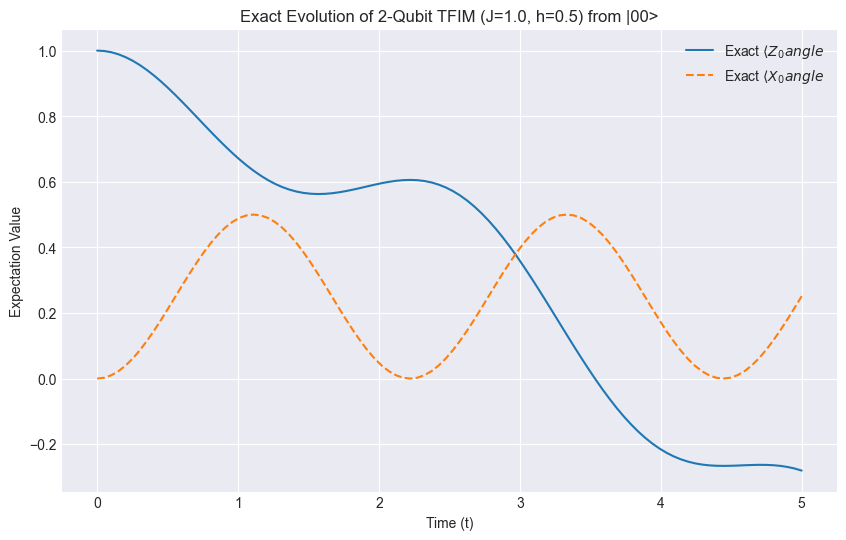

In [3]:
# Simulation parameters.
t_final = 5.0       # Total time evolution
num_steps = 100     # Number of time points
times = np.linspace(0, t_final, num_steps)

# Choose an initial state: |00> = [1, 0, 0, 0]^T
psi0 = np.array([1, 0, 0, 0], dtype=complex)

# Define observables.
# Measure Z on the first qubit: Z ⊗ I
O1 = tensor(Z, I)
# Measure X on the first qubit: X ⊗ I
O2 = tensor(X, I)

# Prepare arrays to hold expectation values over time.
exp_vals_O1_exact = []
exp_vals_O2_exact = []

# Evolve the state and compute expectation values exactly.
for t in times:
    # Compute the exact evolution operator U(t) = exp(-i H t)
    U_t = expm(-1j * H_2qubit * t)
    # Evolve the state
    psi_t = U_t.dot(psi0)
    # Compute expectation values: <psi_t|O|psi_t>
    exp_val1 = np.vdot(psi_t, O1.dot(psi_t)).real  # Should be real for Hermitian O
    exp_val2 = np.vdot(psi_t, O2.dot(psi_t)).real
    exp_vals_O1_exact.append(exp_val1)
    exp_vals_O2_exact.append(exp_val2)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(times, exp_vals_O1_exact, label=r'Exact $\langle Z_0 angle$')
plt.plot(times, exp_vals_O2_exact, label=r'Exact $\langle X_0 angle$', linestyle='--')
plt.xlabel('Time (t)')
plt.ylabel('Expectation Value')
plt.title(f'Exact Evolution of 2-Qubit TFIM (J={J}, h={h}) from |00>')
plt.legend()
plt.grid(True)
plt.show()

## Scaling Up: The 2D Ising Model

Simulating two qubits is feasible, but realistic systems involve many more particles arranged in lattices. Let's consider a 2D rectangular lattice. The Hilbert space dimension grows exponentially ($2^n$), making matrix exponentiation computationally expensive.

We need helper functions to construct operators acting on specific qubits within a larger tensor product space.

In [4]:
# Helper function for the tensor (Kronecker) product of a list of operators.
def tensor_operator(op_list):
    """Compute the tensor product of a list of operators."""
    result = op_list[0]
    for op in op_list[1:]:
        result = np.kron(result, op)
    return result

def single_site_operator(n, site, op):
    """
    Construct the operator acting as 'op' on qubit 'site' (0-indexed)
    and as the identity on all other n-1 qubits.
    """
    if site < 0 or site >= n:
        raise ValueError(f"Site index {site} out of bounds for {n} qubits.")
    op_list = [I] * n
    op_list[site] = op
    return tensor_operator(op_list)

### Constructing the 2D TFIM Hamiltonian

We'll define a 2x3 lattice (6 qubits) with nearest-neighbor interactions ($J$) and a uniform transverse field ($h$). We need a mapping from 2D lattice coordinates $(r, c)$ to a linear qubit index $i$.

In [5]:
# Define the 2D lattice dimensions: 2 rows x 3 columns (6 qubits total)
rows, cols = 2, 3
n_qubits = rows * cols

def qubit_index(r, c, cols):
    """Map 2D lattice coordinates (r, c) to a qubit index (0-indexed)."""
    return r * cols + c

# Hamiltonian parameters (can reuse J, h from before or redefine)
# J = 1.0
# h = 0.5

dim = 2**n_qubits
print(f"Simulating {rows}x{cols} = {n_qubits} qubits. Hilbert space dimension = {dim}\n")

# Build the interaction term H_int = J * sum_{<i,j>} Z_i Z_j
H_int = np.zeros((dim, dim), dtype=complex)
print("Building Interaction Term (H_int):")
for r in range(rows):
    for c in range(cols):
        i = qubit_index(r, c, cols)
        # Neighbor to the right (if it exists)
        if c < cols - 1:
            j_right = qubit_index(r, c + 1, cols)
            print(f"  Adding interaction Z_{i}Z_{j_right} for ({r},{c}) - ({r},{c+1})")
            # Construct operator: Z on i and Z on j, identity elsewhere.
            op = single_site_operator(n_qubits, i, Z) @ single_site_operator(n_qubits, j_right, Z)
            H_int += J * op
        # Neighbor below (if it exists)
        if r < rows - 1:
            j_down = qubit_index(r + 1, c, cols)
            print(f"  Adding interaction Z_{i}Z_{j_down} for ({r},{c}) - ({r+1},{c})")
            op = single_site_operator(n_qubits, i, Z) @ single_site_operator(n_qubits, j_down, Z)
            H_int += J * op

# Build the local field term H_local = h * sum_{i} X_i
H_local = np.zeros((dim, dim), dtype=complex)
print("\nBuilding Field Term (H_local):")
for i in range(n_qubits):
    print(f"  Adding field X_{i}")
    H_local += h * single_site_operator(n_qubits, i, X)

# Full Hamiltonian: H = H_int + H_local
H_6qubit = H_int + H_local

# Optional: Print sparsity info
sparsity = 100 * np.count_nonzero(H_6qubit) / (dim*dim)
print(f"\nFull {n_qubits}-qubit Hamiltonian constructed. Sparsity: {sparsity:.2f}%")

Simulating 2x3 = 6 qubits. Hilbert space dimension = 64

Building Interaction Term (H_int):
  Adding interaction Z_0Z_1 for (0,0) - (0,1)
  Adding interaction Z_0Z_3 for (0,0) - (1,0)
  Adding interaction Z_1Z_2 for (0,1) - (0,2)
  Adding interaction Z_1Z_4 for (0,1) - (1,1)
  Adding interaction Z_2Z_5 for (0,2) - (1,2)
  Adding interaction Z_3Z_4 for (1,0) - (1,1)
  Adding interaction Z_4Z_5 for (1,1) - (1,2)

Building Field Term (H_local):
  Adding field X_0
  Adding field X_1
  Adding field X_2
  Adding field X_3
  Adding field X_4
  Adding field X_5

Full 6-qubit Hamiltonian constructed. Sparsity: 10.94%


### Simulating the 2D System

Now, let's perform the exact simulation for the 6-qubit system starting from the $|000000\rangle$ state and observe the total magnetization along Z, $M_Z = \frac{1}{n} \sum_{i=1}^n Z_i$.


Starting exact evolution for 6 qubits up to t=5.0...
Exact evolution complete.


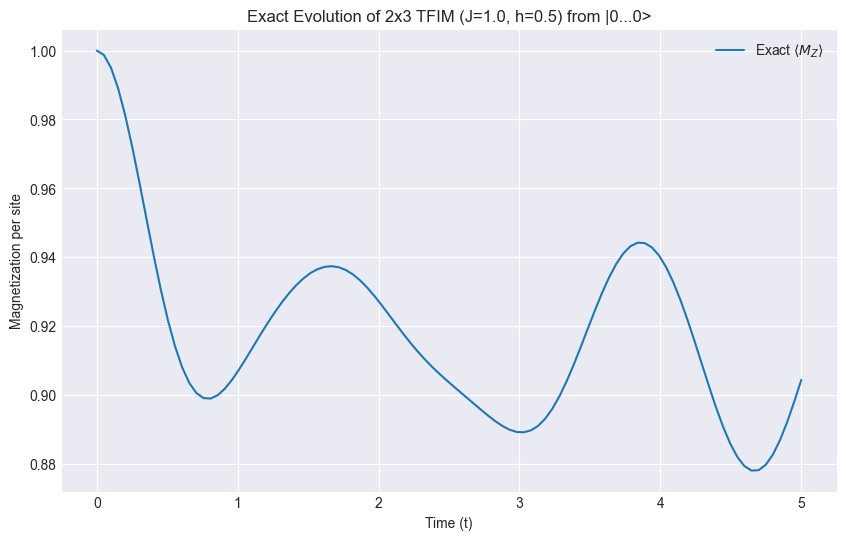

In [11]:
# Simulation parameters (reuse t_final, num_steps, times from before)
# t_final = 5.0
# num_steps = 100
# times = np.linspace(0, t_final, num_steps)

# Choose an initial state: |0...0> (all qubits in |0>).
psi0_6qubit = np.zeros((dim,), dtype=complex)
psi0_6qubit[0] = 1.0

# Define an observable: total Z magnetization per site, O_Mz = (1/n) * sum_{i} Z_i.
def total_Z_operator(n):
    """Construct the sum Z operator on n qubits."""
    op_sum = np.zeros((2**n, 2**n), dtype=complex)
    for i in range(n):
        op_sum += single_site_operator(n, i, Z)
    return op_sum

O_total_Z = total_Z_operator(n_qubits)
O_Mz = (1/n_qubits) * O_total_Z # Magnetization per site

# Arrays to store expectation values over time.
exp_vals_Mz_exact = []

print(f"\nStarting exact evolution for {n_qubits} qubits up to t={t_final}...")
# Evolve the state and compute expectation values.
for t in times:
    # Exact time evolution: U(t) = exp(-i H t)
    # This can be computationally intensive for larger n!
    U_t = expm(-1j * H_6qubit * t)
    psi_t = U_t.dot(psi0_6qubit)
    # Expectation value: <psi_t| O_Mz |psi_t>
    exp_val = np.vdot(psi_t, O_Mz.dot(psi_t)).real
    exp_vals_Mz_exact.append(exp_val)

print("Exact evolution complete.")

# Plot the total Z magnetization per site over time.
plt.figure(figsize=(10, 6))
plt.plot(times, exp_vals_Mz_exact, label=r'Exact $\langle M_Z \rangle$')
plt.xlabel('Time (t)')
plt.ylabel('Magnetization per site')
plt.title(f'Exact Evolution of 2x3 TFIM (J={J}, h={h}) from |0...0>')
plt.legend()
plt.grid(True)
plt.show()

## Hamiltonian Simulation via Trotterization

Directly computing $e^{-iHt}$ using matrix exponentiation is often infeasible for large systems due to the exponential scaling of matrix size. Furthermore, quantum computers typically operate by applying sequences of simple, local quantum gates.

The challenge arises when the Hamiltonian $H$ is a sum of terms that do **not commute**. In our TFIM example, $H = H_{int} + H_{field}$. Let's check if $H_{int}$ (composed of Z operators) and $H_{field}$ (composed of X operators) commute for the 2-qubit case: $H = H_1 + H_2$.

In general, if $[A, B] = AB - BA \neq 0$, then $e^{A+B} \neq e^A e^B$. This non-commutativity prevents us from simply evolving under each part of the Hamiltonian separately and multiplying the results.

In [12]:
# Check commutativity for the 2-qubit case: [H1, H2] = H1*H2 - H2*H1
commutator = H1 @ H2 - H2 @ H1

# Check if the commutator is close to the zero matrix
is_zero = np.allclose(commutator, np.zeros_like(commutator))

print(f"Checking commutativity for 2-qubit H = H1 + H2:")
print(f"[H1, H2] is zero: {is_zero}")
if not is_zero:
    print("Since H1 and H2 do not commute, e^{-i(H1+H2)t} != e^{-iH1 t}e^{-iH2 t}")

Checking commutativity for 2-qubit H = H1 + H2:
[H1, H2] is zero: False
Since H1 and H2 do not commute, e^{-i(H1+H2)t} != e^{-iH1 t}e^{-iH2 t}


### The Lie Product Formula (Trotter-Suzuki Decomposition)

Lie theory provides a way to approximate the evolution under $H=A+B$ even when $[A, B] \neq 0$. The **Lie product formula (or first-order Trotter formula)** states that:
$$ e^{(A+B)t} = \lim_{N \to \infty} \left( e^{At/N} e^{Bt/N} \right)^N $$

For a finite number of steps $N$, we can approximate the evolution over a total time $t$ by breaking it into $N$ small time steps $\delta t = t/N$:
$$ U(t) = e^{-iHt} \approx U_{Trotter}^{(1)}(t) = \left( e^{-iH_1 \delta t} e^{-iH_2 \delta t} \right)^N $$

This is useful because we might know how to implement $e^{-iH_1 \delta t}$ and $e^{-iH_2 \delta t}$ efficiently (e.g., if $H_1$ and $H_2$ correspond to simple gate operations).

### Error Analysis via Baker-Campbell-Hausdorff (BCH)

How good is this approximation? The **Baker-Campbell-Hausdorff (BCH)** formula describes the product of matrix exponentials:
$$ e^X e^Y = e^{Z} \quad \text{where} \quad Z = X + Y + \frac{1}{2}[X, Y] + \frac{1}{12}[X, [X, Y]] - \frac{1}{12}[Y, [X, Y]] + \dots $$

Applying this to a single Trotter step with $X = -iH_1 \delta t$ and $Y = -iH_2 \delta t$:
$$ e^{-iH_1 \delta t} e^{-iH_2 \delta t} = \exp\left( -i(H_1+H_2)\delta t + \frac{1}{2}(-i \delta t)^2 [H_1, H_2] + O(\delta t^3) \right) $$
$$ e^{-iH_1 \delta t} e^{-iH_2 \delta t} \approx \exp\left( -i(H_1+H_2)\delta t - \frac{\delta t^2}{2} [H_1, H_2] \right) $$

The difference between the exact evolution for one step, $e^{-i(H_1+H2)\delta t}$, and the first-order Trotter step is dominated by the commutator term, scaling as $O(\delta t^2)$. Over $N$ steps (total time $t = N \delta t$), the accumulated error typically scales as $N \times O(\delta t^2) = N \times O((t/N)^2) = O(t^2/N)$. The error decreases as we increase the number of Trotter steps $N$.

A more accurate approximation is the **second-order Trotter formula (symmetric)**:
$$ U(t) \approx U_{Trotter}^{(2)}(t) = \left( e^{-iH_1 \delta t/2} e^{-iH_2 \delta t} e^{-iH_1 \delta t/2} \right)^N $$
The error per step for this symmetric decomposition is $O(\delta t^3)$, leading to a total error of $O(t^3/N^2)$, which converges faster.

### Implementing Trotter Simulation (1st and 2nd Order)

Let's implement both the first-order and second-order Trotter simulations for the 2-qubit system and calculate the expectation values over time. We will then compare them to the exact evolution.

In [13]:
# Trotter simulation parameters (same N for comparison)
N_trotter = 10  # Number of Trotter steps (try changing this, e.g., 5, 20, 50)

# --- 1st Order Calculation ---
exp_vals_O1_trotter1 = []
exp_vals_O2_trotter1 = []
print(f"Starting 1st order Trotter evolution (N={N_trotter}) for 2 qubits...")
psi_t_trotter1 = psi0.copy()
for t_idx, t in enumerate(times):
    if t == 0:
        psi_t_trotter1 = psi0.copy()
    else:
        psi_t_trotter1 = psi0.copy() # Simulate from 0 to t
        if N_trotter > 0:
            dt = t / N_trotter
            U1_step = expm(-1j * H1 * dt)
            U2_step = expm(-1j * H2 * dt)
            U_trotter1_step = U1_step @ U2_step # 1st Order
            for _ in range(N_trotter):
                psi_t_trotter1 = U_trotter1_step.dot(psi_t_trotter1)
    # Compute and store expectation values
    exp_val1 = np.vdot(psi_t_trotter1, O1.dot(psi_t_trotter1)).real
    exp_val2 = np.vdot(psi_t_trotter1, O2.dot(psi_t_trotter1)).real
    exp_vals_O1_trotter1.append(exp_val1)
    exp_vals_O2_trotter1.append(exp_val2)
print("1st Order Trotter evolution complete.")

# --- 2nd Order Calculation ---
exp_vals_O1_trotter2 = []
exp_vals_O2_trotter2 = []
print(f"\nStarting 2nd order Trotter evolution (N={N_trotter}) for 2 qubits...")
psi_t_trotter2 = psi0.copy()
for t_idx, t in enumerate(times):
    if t == 0:
        psi_t_trotter2 = psi0.copy()
    else:
        psi_t_trotter2 = psi0.copy() # Simulate from 0 to t
        if N_trotter > 0:
            dt = t / N_trotter
            U1_half_step = expm(-1j * H1 * dt / 2.0)
            U2_full_step = expm(-1j * H2 * dt)
            U_trotter2_step = U1_half_step @ U2_full_step @ U1_half_step # 2nd Order
            for _ in range(N_trotter):
                psi_t_trotter2 = U_trotter2_step.dot(psi_t_trotter2)
    # Compute and store expectation values
    exp_val1 = np.vdot(psi_t_trotter2, O1.dot(psi_t_trotter2)).real
    exp_val2 = np.vdot(psi_t_trotter2, O2.dot(psi_t_trotter2)).real
    exp_vals_O1_trotter2.append(exp_val1)
    exp_vals_O2_trotter2.append(exp_val2)
print("2nd Order Trotter evolution complete.")

Starting 1st order Trotter evolution (N=10) for 2 qubits...
1st Order Trotter evolution complete.

Starting 2nd order Trotter evolution (N=10) for 2 qubits...
2nd Order Trotter evolution complete.


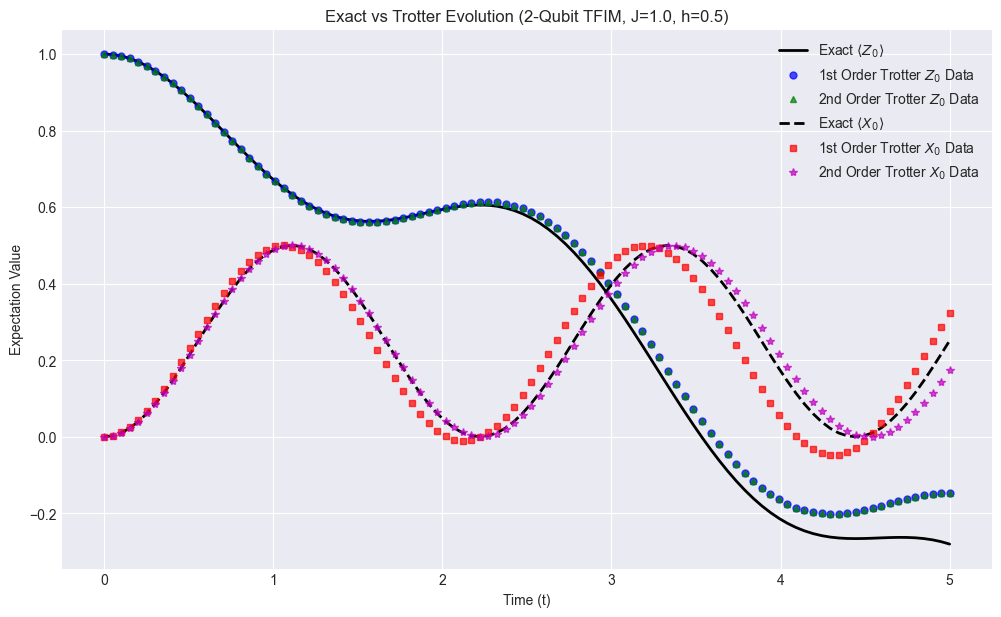

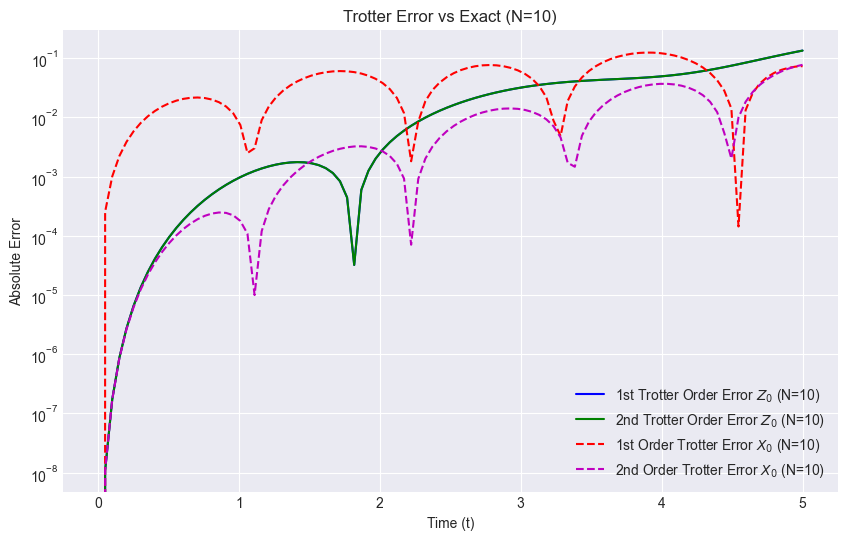

In [18]:
# --- Plot Comparison (Exact vs 1st Order vs 2nd Order) ---
plt.figure(figsize=(12, 7))

# Z0 Expectation
plt.plot(times, exp_vals_O1_exact, 'k-', linewidth=2, label=r'Exact $\langle Z_0 \rangle$')
plt.plot(times, exp_vals_O1_trotter1, 'bo', markersize=5, alpha=0.7, label=f'1st Order Trotter $Z_0$ Data')
plt.plot(times, exp_vals_O1_trotter2, 'g^', markersize=5, alpha=0.7, label=f'2nd Order Trotter $Z_0$ Data')

# X0 Expectation
plt.plot(times, exp_vals_O2_exact, 'k--', linewidth=2, label=r'Exact $\langle X_0 \rangle$')
plt.plot(times, exp_vals_O2_trotter1, 'rs', markersize=5, alpha=0.7, label=f'1st Order Trotter $X_0$ Data')
plt.plot(times, exp_vals_O2_trotter2, 'm*', markersize=6, alpha=0.7, label=f'2nd Order Trotter $X_0$ Data')

plt.xlabel('Time (t)')
plt.ylabel('Expectation Value')
plt.title(f'Exact vs Trotter Evolution (2-Qubit TFIM, J={J}, h={h})')
plt.legend()
plt.grid(True)
plt.show()

# --- Calculate and Plot Errors (1st vs 2nd Order) ---
error_O1_1 = np.abs(np.array(exp_vals_O1_exact) - np.array(exp_vals_O1_trotter1))
error_O2_1 = np.abs(np.array(exp_vals_O2_exact) - np.array(exp_vals_O2_trotter1))
error_O1_2 = np.abs(np.array(exp_vals_O1_exact) - np.array(exp_vals_O1_trotter2))
error_O2_2 = np.abs(np.array(exp_vals_O2_exact) - np.array(exp_vals_O2_trotter2))

plt.figure(figsize=(10, 6))

# Z0 Error
plt.plot(times, error_O1_1, 'b-', label=f'1st Trotter Order Error $Z_0$ (N={N_trotter})')
plt.plot(times, error_O1_2, 'g-', label=f'2nd Trotter Order Error $Z_0$ (N={N_trotter})')

# X0 Error
plt.plot(times, error_O2_1, 'r--', label=f'1st Order Trotter Error $X_0$ (N={N_trotter})')
plt.plot(times, error_O2_2, 'm--', label=f'2nd Order Trotter Error $X_0$ (N={N_trotter})')


plt.xlabel('Time (t)')
plt.ylabel('Absolute Error')
plt.title(f'Trotter Error vs Exact (N={N_trotter})')
plt.legend()
plt.grid(True)
plt.yscale('log') # Log scale highlights scaling differences
plt.show()

Starting 1st order Trotter evolution (N=10) for 2 qubits...
Trotter evolution complete.


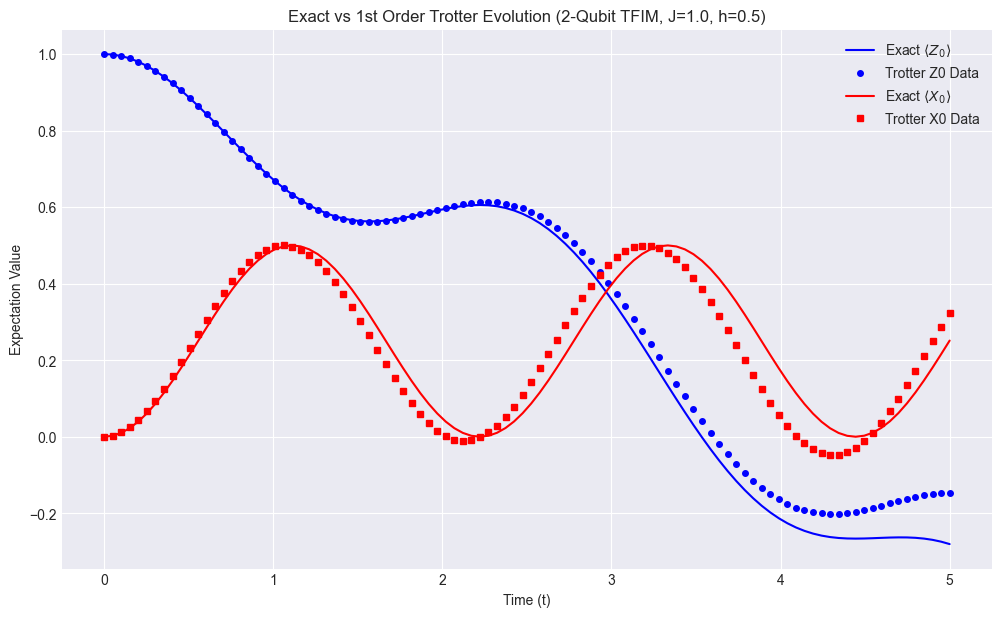

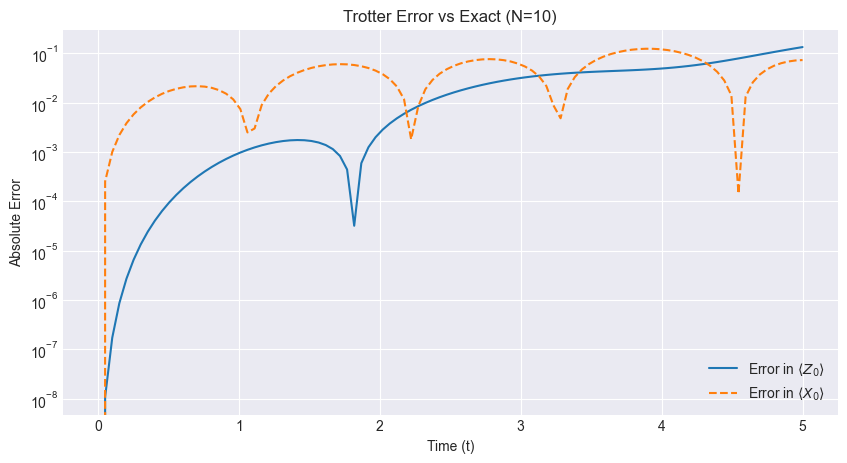

In [10]:
# Trotter simulation parameters
N_trotter = 10  # Number of Trotter steps (try changing this, e.g., 5, 20, 50)

# Arrays for Trotter expectation values
exp_vals_O1_trotter = []
exp_vals_O2_trotter = []

print(f"Starting 1st order Trotter evolution (N={N_trotter}) for 2 qubits...")

psi_t_trotter = psi0.copy() # Start with the initial state

# Pre-calculate the evolution operators for one Trotter step dt
# We need to recalculate dt for each time point in the `times` array

for t_idx, t in enumerate(times):
    if t == 0:
        psi_t_trotter = psi0.copy()
    else:
        # To get to time t from time times[t_idx-1], we need to apply Trotter steps
        # This approach is slightly inefficient; better to simulate step-by-step
        # Let's simulate from 0 to t using N_trotter steps for *this* t
        psi_t_trotter = psi0.copy()
        if N_trotter > 0:
            dt = t / N_trotter
            U1_step = expm(-1j * H1 * dt)
            U2_step = expm(-1j * H2 * dt)
            U_trotter_step = U1_step @ U2_step # Order matters!
            
            for _ in range(N_trotter):
                psi_t_trotter = U_trotter_step.dot(psi_t_trotter)
        else: # If N_trotter is 0, treat as exact? Or handle differently?
              # For simplicity, let's assume N_trotter >= 1 for the plot
              # A N_trotter=0 case would just be the initial state.
              pass 
            
    # Compute expectation values for the Trotter-evolved state
    exp_val1 = np.vdot(psi_t_trotter, O1.dot(psi_t_trotter)).real
    exp_val2 = np.vdot(psi_t_trotter, O2.dot(psi_t_trotter)).real
    exp_vals_O1_trotter.append(exp_val1)
    exp_vals_O2_trotter.append(exp_val2)

print("Trotter evolution complete.")

# Plot comparison
plt.figure(figsize=(12, 7))
plt.plot(times, exp_vals_O1_exact, 'b-', label=r'Exact $\langle Z_0 \rangle$')
plt.plot(times, exp_vals_O1_trotter, 'bo', markersize=4, label='Trotter Z0 Data')

plt.plot(times, exp_vals_O2_exact, 'r-', label=r'Exact $\langle X_0 \rangle$')
plt.plot(times, exp_vals_O2_trotter, 'rs', markersize=4, label='Trotter X0 Data')

plt.xlabel('Time (t)')
plt.ylabel('Expectation Value')
plt.title(f'Exact vs 1st Order Trotter Evolution (2-Qubit TFIM, J={J}, h={h})')
plt.legend()
plt.grid(True)
plt.show()

# Optional: Calculate and plot the error
error_O1 = np.abs(np.array(exp_vals_O1_exact) - np.array(exp_vals_O1_trotter))
error_O2 = np.abs(np.array(exp_vals_O2_exact) - np.array(exp_vals_O2_trotter))


plt.figure(figsize=(10, 5))
plt.plot(times, error_O1, label=r'Error in $\langle Z_0 \rangle$')
plt.plot(times, error_O2, label=r'Error in $\langle X_0 \rangle$', linestyle='--')
plt.xlabel('Time (t)')
plt.ylabel('Absolute Error')
plt.title(f'Trotter Error vs Exact (N={N_trotter})')
plt.legend()
plt.grid(True)
plt.yscale('log') # Often helpful to see error scaling
plt.show()

# Summary & Further Exploration
In this notebook, we explored:

- Constructing the **Hamiltonian for the Transverse-Field Ising Model** in 1D (2 qubits) and 2D (6 qubits).
- Computing **exact quantum time evolution** using the matrix exponential $e^{-iHt}$, a direct application of Lie group theory.
- The challenge posed by **non-commuting Hamiltonian terms** $[H_1, H_2] \neq 0$.
- **Trotterization** (Lie product formula) as a practical method to approximate $e^{-i(H_1+H_2)t}$ by sequences like $(e^{-iH_1 \delta t} e^{-iH_2 \delta t})^N$.
- How the **Baker-Campbell-Hausdorff (BCH)** formula explains the origin and scaling of the Trotter error, linking it directly to the commutator $[H_1, H_2]$.

### Next Steps:
- **Increase `N_trotter`:** Observe how the Trotter approximation converges to the exact result and how the error decreases.
- **Implement 2nd Order Trotter:** Code the symmetric Trotter formula and compare its accuracy (error should scale as $O(t^3/N^2)$).
- **Trotterize the 2D System:** Apply Trotterization to the 6-qubit `H_6qubit`. Note that exponentiating `H_int` and `H_local` separately might still be hard classically, but on a quantum computer, sequences of gates can implement these steps.
- **Explore Different Parameters:** Change $J$ and $h$ to see how the system dynamics and Trotter error change (e.g., near a phase transition).
- **Higher-Order BCH Terms:** Consider the impact of higher-order commutators in the BCH formula on the Trotter error.

Understanding Hamiltonian simulation, Trotterization, and BCH error analysis is crucial for developing and analyzing algorithms for quantum computers, connecting fundamental Lie theory to practical quantum computation.

![QF-Mission](https://quantumformalism.academy/img/qf-down.png)

**Copyright © 2025 Quantum Formalism Academy. All rights reserved.**

This notebook is a product of **Quantum Formalism Academy** and is intended for educational purposes. Redistribution, modification, or commercial use of this material without prior written permission from Quantum Formalism is prohibited.